In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib
from matplotlib.pyplot import figure

/Users/sreeram/opt/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
torch.manual_seed(1)

In [3]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [4]:
# Data loader func
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

In [5]:
class DNN(nn.Module):
    def __init__(self,):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        # flatten as one dimension
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
# m = DNN()
# p1=torch.nn.utils.parameters_to_vector(m.fc1.weight.data).detach().numpy()

# print(p1)

In [7]:
# testDict = {}

# for name, parameter in m.named_parameters():
#     if'weight' in name:
#         testDict['b'] = (torch.nn.utils.parameters_to_vector(parameter).detach().numpy())
#         #testDict['b'].append(weights2)
# len(testDict)

In [8]:
# temp_df = pd.DataFrame()
# for name, parameter in m.named_parameters():
#             if 'weight' in name:
#                 weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
#                 temp_df = pd.concat([temp_df, pd.DataFrame(weights).T], axis = 1)
                
# temp_df

In [9]:
# temp_df = pd.DataFrame()
# for name, parameter in m.named_parameters():
#             if 'weight' in name and 'fc3'in name:
#                 weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
#                 temp_df = pd.concat([temp_df, pd.DataFrame(weights).T], axis = 1)
                
# temp_df

In [10]:
# print(p1 == p2)

In [11]:
def trainFunc(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('started')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    epoch = 0
    modelParamWgt = pd.DataFrame()
    trainAvgLossArr = []
    trainAvgAccArr = []
    firstParaWgt = {}

    for epoch in range (num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0
        totalacc=0
        epoch_df = pd.DataFrame()

        for i, (images, labels) in enumerate(train_load):  
            #if (i+1)% 60 == 0 : print(i+1)
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
            # Forward pass
            prediction = model(images)

            images.requires_grad = True

            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()

            # Backward and optimize
            
            loss.backward()

            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            totalacc += acc

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)

            #Print Status
            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True)
        
        #Weight Collection
        for name, parameter in model.named_parameters():
            #print(name)
            if'weight' in name:
                weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
                epoch_df = pd.concat([epoch_df, pd.DataFrame(weights).T], axis = 1) 

        modelParamWgt = pd.concat([modelParamWgt, epoch_df], axis = 0)     

       
        epochLoss = lossSum/n_total_steps
        epochAcc = totalacc/n_total_steps
        #print("Train Avg loss:",trainAvgLoss)
        trainAvgLossArr.append(epochLoss)    
        trainAvgAccArr.append(epochAcc)
                       
    return train_epoch,train_losses,train_acc,trainAvgLossArr,trainAvgAccArr, modelParamWgt,firstParaWgt


In [12]:
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}',end= '\r',flush = True)
    return netTest_acc1, netTest_loss

In [13]:
def pcaOps(paramDF,itr):
    pcaOperation =  PCA(n_components=2)

    pcaVal = pcaOperation.fit_transform(paramDF)

    itrData = np.full((pcaVal.shape[0],1),itr)

    pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    return pcaDf


In [14]:
a=[]
tempModel = DNN()
for i in tempModel.parameters():
    a.append(torch.numel(i))
print(f'Total no of parameters:{np.sum(a)}')

Total no of parameters:418060


In [15]:
#2nd Approach

max_epochs = 45
all_df = pd.DataFrame()
columns=["x","y","Times"]
trainAllacc={}
testAllacc={}
trainAllloss={}
testAllloss={}
train_batch_size = 1000
test_batch_size = 1000
status_interval = 60
loss_func = nn.CrossEntropyLoss()
firstLayer = pd.DataFrame()

for count in range(6):

    j = copy.deepcopy(count)

    j = DNN()  

    print("Time: "+str(count))
    optimizer = torch.optim.Adam(j.parameters(),lr = 0.0004,weight_decay=1e-4)
    model_name1 = "Times:"+str(count)  
    
    train_epoch,train_losses,train_acc,trainAvgLoss,trainAvgAccArr, modelParamWgt,firstParamWgt = trainFunc(j,max_epochs,train_batch_size,status_interval)
    testAcc, testLoss = testFunction(j,loss_func,test_batch_size)

    all_df = all_df.append(modelParamWgt)
    
    testAllacc[count] = testAcc
    trainAllloss[count] = trainAvgLoss
    testAllloss[count] = testLoss
    trainAllacc[count] = trainAvgAccArr


Time: 0
started
Time: 1y of the network on the test images: 98.03% & Test Loss: 0.06382435336709022
started
Time: 2y of the network on the test images: 98.03% & Test Loss: 0.06331406161189079
started
Time: 3y of the network on the test images: 98.01% & Test Loss: 0.06134082255885005
started
Time: 4y of the network on the test images: 97.97% & Test Loss: 0.06468595955520869
started
Time: 5y of the network on the test images: 97.88% & Test Loss: 0.06472811959683895
started


In [16]:
trainAccArr = []
for key,values in enumerate(trainAllacc):
    trainAccArr.append(trainAllacc[key])
trainLossArr = []
for key,values in enumerate(trainAllloss):
    trainLossArr.append(trainAllloss[key])


In [17]:
all_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,8.407491e-03,3.342576e-05,-1.456759e-05,-1.231873e-05,5.416777e-05,3.672396e-03,5.604157e-04,4.590639e-04,1.064807e-02,-9.778965e-03,...,0.010897,-0.138840,0.063458,-0.071111,0.081551,0.138086,-0.043712,-0.063955,0.040641,-0.140893
0,8.579934e-04,-7.691920e-06,3.082583e-05,1.864881e-07,2.536466e-06,-6.868055e-05,-7.803684e-06,-3.594808e-05,1.683692e-03,-1.337990e-03,...,0.002337,-0.150779,0.069672,-0.070533,0.088662,0.147685,-0.058465,-0.069541,0.035195,-0.160224
0,-4.852837e-06,-6.665600e-07,-1.637775e-06,1.594691e-08,-1.883520e-08,1.961095e-06,-2.079883e-06,-1.123317e-06,7.284515e-05,-3.240443e-05,...,0.000816,-0.155347,0.071687,-0.070061,0.091018,0.152728,-0.069894,-0.073258,0.033361,-0.176232
0,-8.169367e-07,3.363222e-08,-8.366477e-08,4.392720e-11,1.042153e-09,-1.770799e-07,5.613213e-08,-2.368314e-08,-2.996618e-06,2.475842e-06,...,-0.000699,-0.158250,0.073490,-0.070794,0.092651,0.156677,-0.078269,-0.075961,0.032948,-0.187836
0,4.876693e-08,-1.464078e-09,-2.386446e-09,-4.365271e-11,-2.059946e-10,1.211538e-08,4.804896e-09,-1.310920e-09,3.535060e-08,-8.517915e-08,...,-0.001478,-0.161685,0.074900,-0.071725,0.093617,0.160056,-0.085360,-0.078986,0.032997,-0.200260
0,-2.052271e-09,5.814540e-11,-8.712783e-11,4.764165e-13,-2.135061e-12,-2.544185e-10,1.742683e-10,-1.114143e-10,1.026400e-09,2.878332e-09,...,-0.002447,-0.165146,0.076387,-0.072989,0.094927,0.163454,-0.091040,-0.081491,0.033159,-0.211036
0,6.313024e-11,-1.276764e-13,-5.234340e-12,3.289161e-14,4.638263e-14,-1.852810e-11,6.100513e-12,-5.400888e-12,-7.073228e-11,-1.292195e-10,...,-0.003076,-0.168535,0.077028,-0.075351,0.096147,0.165963,-0.097573,-0.084729,0.032601,-0.222035
0,-1.720803e-13,-1.194039e-13,-3.089129e-13,-2.237877e-15,-3.133157e-15,3.785441e-13,2.846283e-13,2.500885e-14,1.231429e-12,7.004771e-12,...,-0.003799,-0.172293,0.078544,-0.076365,0.097233,0.168772,-0.102026,-0.087156,0.032983,-0.231573
0,-1.409077e-13,-1.825239e-15,-9.784630e-15,9.065367e-17,-6.357189e-16,4.126671e-14,1.553529e-14,1.053934e-14,1.382754e-13,-3.374294e-13,...,-0.004113,-0.176690,0.079244,-0.078029,0.098465,0.171614,-0.108288,-0.089451,0.032794,-0.241099
0,8.204573e-15,8.251594e-17,2.288962e-16,-2.077027e-18,-1.817676e-17,1.235189e-15,6.770606e-16,-2.499485e-16,-1.625735e-14,9.537745e-15,...,-0.004760,-0.179118,0.080215,-0.079614,0.100201,0.174495,-0.113987,-0.091000,0.033054,-0.249760


In [18]:
train_acc_df = pd.DataFrame(trainAccArr)
train_acc_data = np.array(train_acc_df).flatten()

train_loss_df = pd.DataFrame(trainLossArr)
train_loss_data = np.array(train_loss_df).flatten()

print(f'Shape of Loss:{np.shape(train_loss_data)} & Shape of Acc: {np.shape(train_acc_data)}')


Shape of Loss:(270,) & Shape of Acc: (270,)


In [19]:
t1 = all_df
print(pd.DataFrame(t1))

             0             1             2             3             4    \
0   8.407491e-03  3.342576e-05 -1.456759e-05 -1.231873e-05  5.416777e-05   
0   8.579934e-04 -7.691920e-06  3.082583e-05  1.864881e-07  2.536466e-06   
0  -4.852837e-06 -6.665600e-07 -1.637775e-06  1.594691e-08 -1.883520e-08   
0  -8.169367e-07  3.363222e-08 -8.366477e-08  4.392720e-11  1.042153e-09   
0   4.876693e-08 -1.464078e-09 -2.386446e-09 -4.365271e-11 -2.059946e-10   
0  -2.052271e-09  5.814540e-11 -8.712783e-11  4.764165e-13 -2.135061e-12   
0   6.313024e-11 -1.276764e-13 -5.234340e-12  3.289161e-14  4.638263e-14   
0  -1.720803e-13 -1.194039e-13 -3.089129e-13 -2.237877e-15 -3.133157e-15   
0  -1.409077e-13 -1.825239e-15 -9.784630e-15  9.065367e-17 -6.357189e-16   
0   8.204573e-15  8.251594e-17  2.288962e-16 -2.077027e-18 -1.817676e-17   
0  -1.514253e-17  6.427359e-18  2.345252e-17 -6.318592e-20  1.262108e-18   
0  -1.536074e-17  2.737929e-19 -5.491196e-19  9.773348e-21 -2.693371e-20   
0   3.930923

In [20]:

t1 = np.array(t1)
pca = PCA(n_components=2)
new_data = pca.fit_transform(t1)

allEpochDf = pd.DataFrame(new_data, columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 6
times = np.repeat([i for i in range(8)], max_epochs)

if len(allEpochDf) > len(times):
    times = np.repeat(times, len(allEpochDf) // len(times) + 1)[:len(allEpochDf)]
elif len(allEpochDf) < len(times):
    times = times[:len(allEpochDf)]

allEpochDf['Epoch'] = eps_each_time
allEpochDf['Iteration'] = times
allEpochDf["Acc"] = train_acc_data
allEpochDf["Loss"] = train_loss_data


In [21]:
epoch3Df = allEpochDf.loc[(allEpochDf['Epoch']+1)%3 == 0]
epoch3Df = epoch3Df.reset_index(drop=True)
epoch3Df

,x,y,Epoch,Iteration,Acc,Loss
0,-7.159675,-6.533361,2,0,91.432718,0.294384
1,-8.916479,-8.119801,5,0,94.423357,0.190215
2,-10.091366,-9.171381,8,0,96.013471,0.138692
3,-10.851041,-9.856955,11,0,96.997883,0.106005
4,-11.372025,-10.313524,14,0,97.690940,0.084838
5,-11.730974,-10.635187,17,0,98.220365,0.069536
6,-11.988783,-10.864637,20,0,98.560001,0.058299
7,-12.153337,-11.012700,23,0,98.702035,0.049420
8,-12.271751,-11.108303,26,0,99.014987,0.042562
9,-12.334933,-11.159826,29,0,99.197711,0.034780


In [22]:
test = np.array(epoch3Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))
len(mv)

90

In [23]:
cmap = ['red','blue','purple','green','yellow','brown','black','grey']

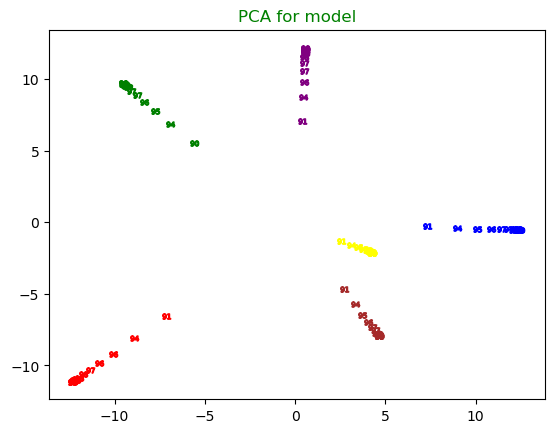

<Figure size 5000x2500 with 0 Axes>

In [24]:

for i in range(len(mv)):
    m = mv[i]
    c = epoch3Df['Iteration'][i]
    plt.scatter(epoch3Df['x'][i],epoch3Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for model",color="g")
    
plt.figure(figsize=[10,5],dpi=500)

plt.savefig('PCA_1Copy.jpg',
            format='jpeg',
            dpi=700,
            bbox_inches='tight')

plt.show()

In [25]:
layer1_Df = all_df.iloc[:,0:7840]


In [26]:
t2 = layer1_Df 
t2 = np.array(t2)
pca = PCA(n_components=2)
new_data2 = pca.fit_transform(t2)

In [37]:
print(len(eps_each_time))
print(len(times))
print(len(train_acc_data))
print(len(train_loss_data))
layer1Df.shape[0]


360
360
270
270


270

In [38]:
layer1Df = pd.DataFrame(new_data2,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

layer1Df['Epoch']=eps_each_time[:layer1Df.shape[0]]
layer1Df['Iteration']=(times[:layer1Df.shape[0]])
layer1Df["Acc"] = train_acc_data
layer1Df["Loss"] = train_loss_data


In [39]:
test = np.array(layer1Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))


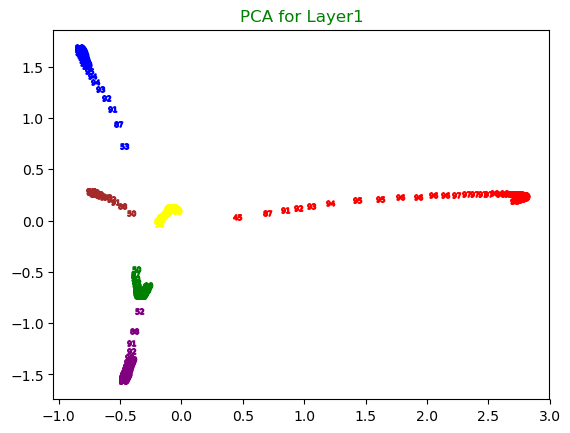

In [40]:
for i in range(len(mv)):
    m = mv[i]
    c = layer1Df['Iteration'][i]
    plt.scatter(layer1Df['x'][i],layer1Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for Layer1",color="g")

plt.savefig('PCA_Layer1.jpg',
            format='jpeg',
            dpi=700,
            bbox_inches='tight')

plt.show()